# Lecture et étude du dataset

--- Chargement des données ---
Chargeent ok : 90000 images totales.

--- Répartition Finale ---
1. TRAIN Set : 72000 images (80.0%) -> Pour apprendre
2. VAL Set   : 15300 images (17.0%) -> Pour régler les hyperparamètres
3. TEST Set  : 2700 images (3.0%) -> Pour l'évaluation finale interne

--- Vérification Équilibre du Train (80%) ---
Femmes : 42430
Hommes : 29570

--- Vérification Équilibre du val (17%) ---
Femmes : 9017
Hommes : 6283

--- Vérification Équilibre du Test Interne (3%) ---
Femmes : 1591
Hommes : 1109


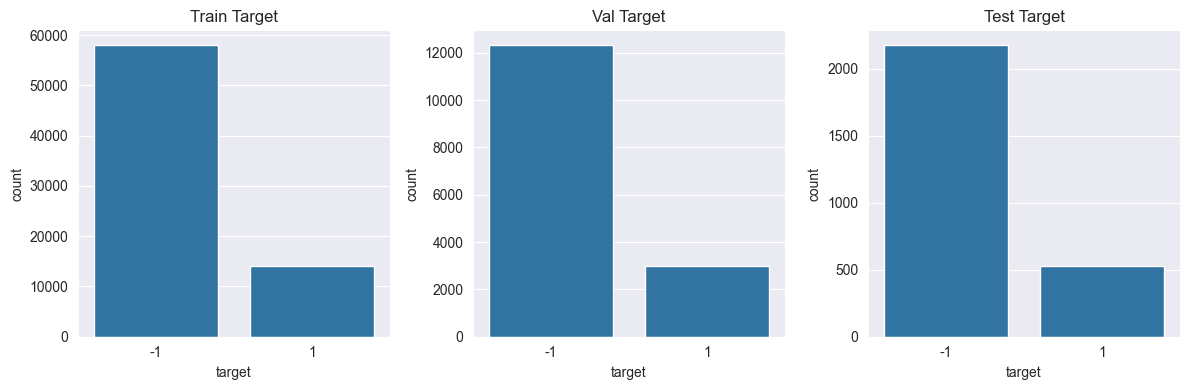

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

TRAIN_DIR = './train'
LABELS_PATH = './train.txt'

print("--- Chargement des données ---")
try:
    df = pd.read_csv(LABELS_PATH, sep=r"\s+", names=['filename', 'target', 'gender'], engine='python')
    df = df.dropna()
    df['target'] = df['target'].astype(int)
    df['gender'] = df['gender'].astype(int)
    print(f"Chargeent ok : {len(df)} images totales.")
except Exception as e:
    print(f"Erreur d charge : {e}")
    raise e

# DÉCOUPAGE (train: 80% - val: 17% - test interne: 3%)
# On crée une colonne pour garder l'équilibre (Target + Genre)
df['stratify_col'] = df['target'].astype(str) + "_" + df['gender'].astype(str)

train_df, temp_df = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df['stratify_col']
)

val_df, test_internal_df = train_test_split(
    temp_df,
    test_size=0.15,
    random_state=42,
    stratify=temp_df['stratify_col']
)

train_df = train_df.drop(columns=['stratify_col'])
val_df = val_df.drop(columns=['stratify_col'])
test_internal_df = test_internal_df.drop(columns=['stratify_col'])


total = len(df)
print("\n--- Répartition Finale ---")
print(f"1. TRAIN Set : {len(train_df)} images ({len(train_df)/total:.1%}) -> Pour apprendre")
print(f"2. VAL Set   : {len(val_df)} images ({len(val_df)/total:.1%}) -> Pour régler les hyperparamètres")
print(f"3. TEST Set  : {len(test_internal_df)} images ({len(test_internal_df)/total:.1%}) -> Pour l'évaluation finale interne")

print("\n--- Vérification Équilibre du Train (80%) ---")
train_gender_counts = train_df['gender'].value_counts()
print(f"Femmes : {train_gender_counts.get(-1, 0)}")
print(f"Hommes : {train_gender_counts.get(1, 0)}")

print("\n--- Vérification Équilibre du val (17%) ---")
val_gender_counts = val_df['gender'].value_counts()
print(f"Femmes : {val_gender_counts.get(-1, 0)}")
print(f"Hommes : {val_gender_counts.get(1, 0)}")

print("\n--- Vérification Équilibre du Test Interne (3%) ---")
test_internal_gender_counts = test_internal_df['gender'].value_counts()
print(f"Femmes : {test_internal_gender_counts.get(-1, 0)}")
print(f"Hommes : {test_internal_gender_counts.get(1, 0)}")

# Visualisation rapde
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); sns.countplot(x='target', data=train_df); plt.title("Train Target")
plt.subplot(1, 3, 2); sns.countplot(x='target', data=val_df); plt.title("Val Target")
plt.subplot(1, 3, 3); sns.countplot(x='target', data=test_internal_df); plt.title("Test Target")
plt.tight_layout()
plt.show()

# Entraînement du modèle pré-entrainé

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import os
import pandas as pd
import numpy as np
from tqdm import tqdm


BEST_PARAMS = {
    "lr": 1e-4,
    "dropout": 0.5,
    "batch_size": 32,
    "label_smoothing": 0.1
}

EPOCHS = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Démarrage ResNet18 sur : {DEVICE} pour {EPOCHS} époques.")

class FaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        try: image = Image.open(img_path).convert('RGB')
        except: image = Image.new('RGB', (80, 80))

        target = 1.0 if row['target'] == 1 else 0.0
        gender = 1.0 if row['gender'] == 1 else 0.0

        if self.transform: image = self.transform(image)
        return image, torch.tensor(target).float(), torch.tensor(gender).float()

# UPSCALIN
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


print("Création du Sampler Équilibré...")
groups = []
for t, g in zip(train_df['target'], train_df['gender']):
    if g == -1 and t == -1: groups.append(0)
    elif g == -1 and t == 1: groups.append(1)
    elif g == 1 and t == -1: groups.append(2)
    elif g == 1 and t == 1: groups.append(3)

groups = np.array(groups)
class_counts = np.bincount(groups)
class_weights = 1. / class_counts
sample_weights = class_weights[groups]
sampler = WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights))

train_dataset = FaceDataset(train_df, TRAIN_DIR, transform=train_transforms)
val_dataset = FaceDataset(val_df, TRAIN_DIR, transform=val_transforms)
test_internal_dataset = FaceDataset(test_internal_df, TRAIN_DIR, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BEST_PARAMS['batch_size'], sampler=sampler, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BEST_PARAMS['batch_size'], shuffle=False, num_workers=0)
test_internal_loader = DataLoader(test_internal_dataset, batch_size=BEST_PARAMS['batch_size'], shuffle=False, num_workers=0)

# MODÈLE RESNET18
class ResNetModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNetModel, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 1)
        )

    def forward(self, x):
        return self.model(x)

model = ResNetModel(dropout_rate=BEST_PARAMS['dropout']).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=BEST_PARAMS['lr'])
criterion = nn.BCEWithLogitsLoss()

# ENTRAÎNEMENT
def calculate_esiea_metric(preds, targets, genders):
    preds_bin = (torch.sigmoid(preds) > 0.5).float()
    mask_m, mask_f = (genders == 1), (genders == 0)
    acc_m = (preds_bin[mask_m] == targets[mask_m]).float().mean().item() if mask_m.sum() > 0 else 0
    acc_f = (preds_bin[mask_f] == targets[mask_f]).float().mean().item() if mask_f.sum() > 0 else 0
    return ((acc_m + acc_f) / 2) - (2 * abs(acc_m - acc_f)), acc_m, acc_f

best_score = -float('inf')
print("\nDébut de l'entraînement...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, targets, _ in pbar:
        smooth = BEST_PARAMS['label_smoothing']
        targets_smooth = targets * (1 - smooth) + 0.5 * smooth

        images, targets_smooth = images.to(DEVICE), targets_smooth.to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets_smooth)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

    model.eval()
    all_preds, all_targs, all_gends = [], [], []
    with torch.no_grad():
        for imgs, targs, gends in val_loader:
            imgs = imgs.to(DEVICE)
            all_preds.append(model(imgs).cpu())
            all_targs.append(targs)
            all_gends.append(gends)

    full_preds = torch.cat(all_preds)
    full_targs = torch.cat(all_targs).unsqueeze(1)
    full_gends = torch.cat(all_gends).unsqueeze(1)

    score, acc_h, acc_f = calculate_esiea_metric(full_preds, full_targs, full_gends)

    print(f"   Score (Th=0.5): {score:.4f} | H: {acc_h:.2%} | F: {acc_f:.2%}")

    if score > best_score:
        best_score = score
        torch.save(model.state_dict(), "best_resnet_upscaled.pth")
        print("Modèle sauvegardé.")


# OPTIMISATION DU SEIL
print("\nRecherche du seuil optimal sur le Val Set...")
model.load_state_dict(torch.load("best_resnet_upscaled.pth", map_location=DEVICE))
model.eval()

all_probs = []
with torch.no_grad():
    for imgs, _, _ in val_loader:
        imgs = imgs.to(DEVICE)
        all_probs.append(torch.sigmoid(model(imgs)).cpu())

probs = torch.cat(all_probs).numpy().flatten()
targets = full_targs.numpy().flatten()
genders = full_gends.numpy().flatten()

best_thresh_score = -float('inf')
best_thresh = 0.5

# Test de 0.20 à 0.80
for th in np.arange(0.20, 0.81, 0.01):
    preds = (probs > th).astype(float)
    mask_m = (genders == 1)
    mask_f = (genders == 0)

    acc_m = np.mean(preds[mask_m] == targets[mask_m])
    acc_f = np.mean(preds[mask_f] == targets[mask_f])

    s = (acc_m + acc_f)/2 - 2 * abs(acc_m - acc_f)

    if s > best_thresh_score:
        best_thresh_score = s
        best_thresh = th

print(f"Seuil optimal : {best_thresh:.2f}")
print(f"Score optimisé : {best_thresh_score:.4f} (Gain: {best_thresh_score - best_score:.4f})")

🚀 Démarrage ResNet18 sur : cpu pour 1 époques.
Création du Sampler Équilibré...

Début de l'entraînement...


Epoch 1/1:  13%|█▎        | 291/2250 [11:17<1:16:03,  2.33s/it, loss=0.4]  


KeyboardInterrupt: 

# Local test

In [15]:
print(f"\nTest Interne")

model.load_state_dict(torch.load("best_resnet_upscaled.pth", map_location=DEVICE))
model.eval()

all_probs = []
all_targs = []
all_gends = []

with torch.no_grad():
    for imgs, targs, gends in tqdm(test_internal_loader, desc="Evaluation Test Interne"):
        imgs = imgs.to(DEVICE)

        probs = torch.sigmoid(model(imgs)).cpu()
        all_probs.append(probs)
        all_targs.append(targs)
        all_gends.append(gends)

probs = torch.cat(all_probs).numpy().flatten()
targets = torch.cat(all_targs).numpy().flatten()
genders = torch.cat(all_gends).numpy().flatten()

current_thresh = best_thresh
preds = (probs > current_thresh).astype(float)

mask_m = (genders == 1)
mask_f = (genders == 0)

acc_m = np.mean(preds[mask_m] == targets[mask_m])
acc_f = np.mean(preds[mask_f] == targets[mask_f])
final_score = (acc_m + acc_f)/2 - 2 * abs(acc_m - acc_f)

print(f"\n{'='*40}")
print(f"RESULTATS DÉFINITIFS (Estimation Note)")
print(f"{'='*40}")
print(f"Seuil utilisé       : {current_thresh:.4f}")
print(f"Accuracy Hommes     : {acc_m:.2%}")
print(f"Accuracy Femmes     : {acc_f:.2%}")
print(f"Ecart H/F           : {abs(acc_m - acc_f):.2%}")
print(f"----------------------------------------")
print(f"SCORE ESIEA ESTIMÉ : {final_score:.4f}")
print(f"{'='*40}")

if abs(acc_m - acc_f) > 0.05:
    print("Attention : L'écart H/F est encore élevé (> 5%).")
else:
    print("Excellent : L'écart est maîtrisé.")


Test Interne


Evaluation Test Interne: 100%|██████████| 85/85 [01:02<00:00,  1.37it/s]


RESULTATS DÉFINITIFS (Estimation Note)
Seuil utilisé       : 0.4400
Accuracy Hommes     : 97.29%
Accuracy Femmes     : 91.95%
Ecart H/F           : 5.34%
----------------------------------------
SCORE ESIEA ESTIMÉ : 0.8394
Attention : L'écart H/F est encore élevé (> 5%).


🔍 Recherche du seuil pour aligner Hommes et Femmes...
⚠️ Impossible de trouver un écart < 2% avec ce modèle.
On va prendre le minimum gap absolu...

✅ NOUVEAU SEUIL CHOISI : 0.1000
   Accuracy Hommes : 88.28%
   Accuracy Femmes : 85.36%
   Nouvel Ecart    : 2.92% (vs 5.34% avant)
   🚀 NOUVEAU SCORE: 0.8097


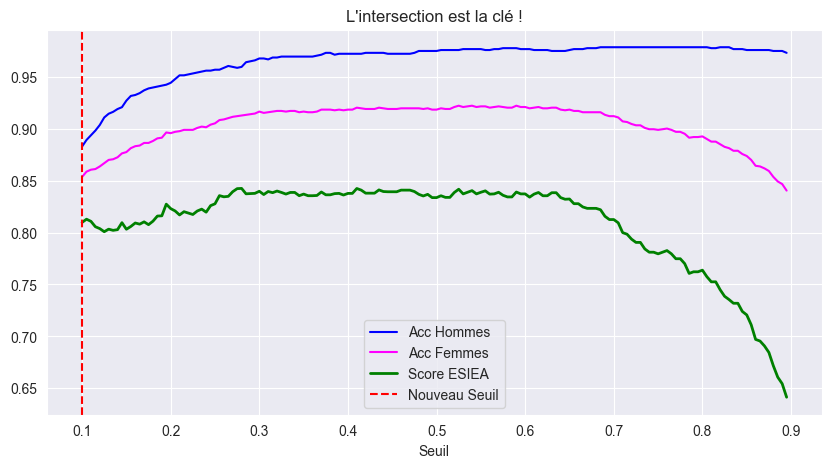

In [16]:
# =============================================================================
# ANALYSE FINE : PRIORITÉ À L'ÉCART (GAP)
# =============================================================================
print("🔍 Recherche du seuil pour aligner Hommes et Femmes...")

best_score_constrained = -1
best_thresh_constrained = 0.5
min_gap = 1.0

# On teste plus de seuils, plus finement
thresholds = np.arange(0.10, 0.90, 0.005)

history = []

for th in thresholds:
    preds = (probs > th).astype(float)

    mask_m = (genders == 1)
    mask_f = (genders == 0)

    acc_m = np.mean(preds[mask_m] == targets[mask_m])
    acc_f = np.mean(preds[mask_f] == targets[mask_f])

    gap = abs(acc_m - acc_f)
    score = (acc_m + acc_f)/2 - 2 * gap

    history.append({'th': th, 'acc_m': acc_m, 'acc_f': acc_f, 'gap': gap, 'score': score})

    # STRATÉGIE : On ne garde que les seuils où l'écart est < 2%
    if gap < 0.02:
        if score > best_score_constrained:
            best_score_constrained = score
            best_thresh_constrained = th
            final_gap = gap
            final_acc_m = acc_m
            final_acc_f = acc_f

if best_score_constrained == -1:
    print("⚠️ Impossible de trouver un écart < 2% avec ce modèle.")
    print("On va prendre le minimum gap absolu...")
    # Fallback : on prend juste le plus petit gap trouvé
    best_run = min(history, key=lambda x: x['gap'])
    best_thresh_constrained = best_run['th']
    best_score_constrained = best_run['score']
    final_acc_m = best_run['acc_m']
    final_acc_f = best_run['acc_f']
    final_gap = best_run['gap']

print(f"\n✅ NOUVEAU SEUIL CHOISI : {best_thresh_constrained:.4f}")
print(f"   Accuracy Hommes : {final_acc_m:.2%}")
print(f"   Accuracy Femmes : {final_acc_f:.2%}")
print(f"   Nouvel Ecart    : {final_gap:.2%} (vs 5.34% avant)")
print(f"   🚀 NOUVEAU SCORE: {best_score_constrained:.4f}")

# Visualisation pour comprendre
df_hist = pd.DataFrame(history)
plt.figure(figsize=(10, 5))
plt.plot(df_hist['th'], df_hist['acc_m'], label='Acc Hommes', color='blue')
plt.plot(df_hist['th'], df_hist['acc_f'], label='Acc Femmes', color='magenta')
plt.plot(df_hist['th'], df_hist['score'], label='Score ESIEA', color='green', linewidth=2)
plt.axvline(best_thresh_constrained, color='red', linestyle='--', label='Nouveau Seuil')
plt.title("L'intersection est la clé !")
plt.xlabel("Seuil")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
print(f"\nGénération du fichier de rendu FINAL...")

# 1. Chargement de la liste officielle
test_files = []
TEST_DIR = "./test"
TEST_LIST_PATH = "./test.txt"
OUTPUT_FILE = "./predictions/predictions_Binome1_Binome2_Binome3 - v3.txt"

with open(TEST_LIST_PATH, 'r') as f:
    test_files = [line.strip().split()[0] for line in f.readlines() if line.strip()]
print(f"✅ Liste officielle chargée ({len(test_files)} images).")

# 2. Boucle d'Inférence avec TTA
predictions = []
model.eval()

with torch.no_grad():
    for img_name in tqdm(test_files, desc="Inférence + TTA"):
        try:
            path = os.path.join(TEST_DIR, img_name)
            img = Image.open(path).convert('RGB')

            img_t = val_transforms(img).unsqueeze(0).to(DEVICE)
            prob1 = torch.sigmoid(model(img_t)).item()


            img_flip = torch.flip(img_t, [3])
            prob2 = torch.sigmoid(model(img_flip)).item()

            avg_prob = (prob1 + prob2) / 2

            pred_label = 1 if avg_prob > best_thresh else -1
            predictions.append(f"{img_name} {pred_label}")

        except Exception as e:
            print(f"Erreur {img_name}: {e}")
            predictions.append(f"{img_name} -1")

with open(OUTPUT_FILE, 'w') as f:
    f.write('\n'.join(predictions))

print(f"\nFichier généré : {OUTPUT_FILE}")
print("Prêt à être envoyé !")


Génération du fichier de rendu FINAL...
✅ Liste officielle chargée (9999 images).


Inférence + TTA:   1%|          | 90/9999 [00:04<08:11, 20.15it/s] 


KeyboardInterrupt: 